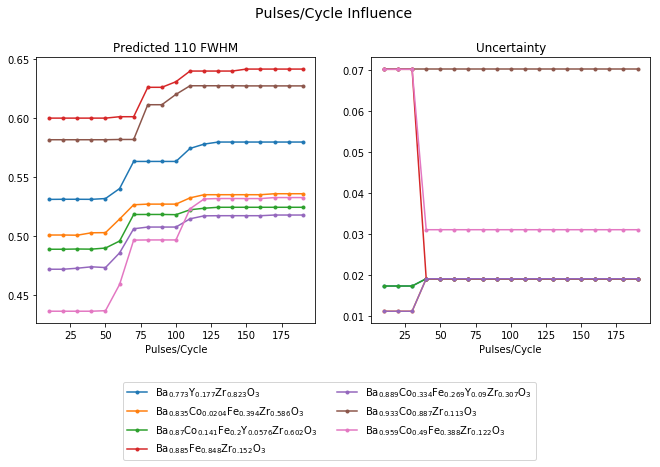

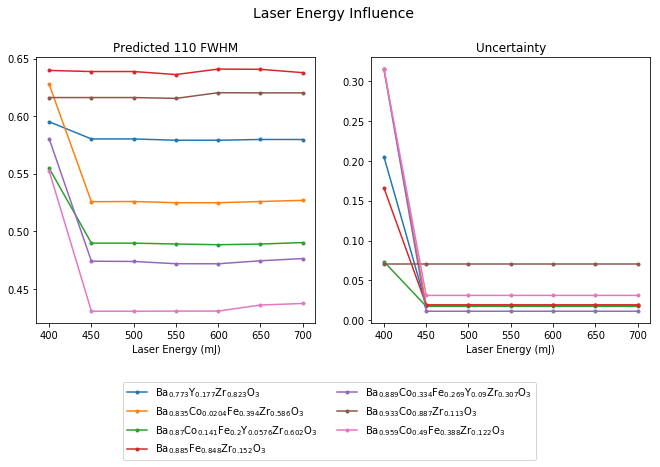

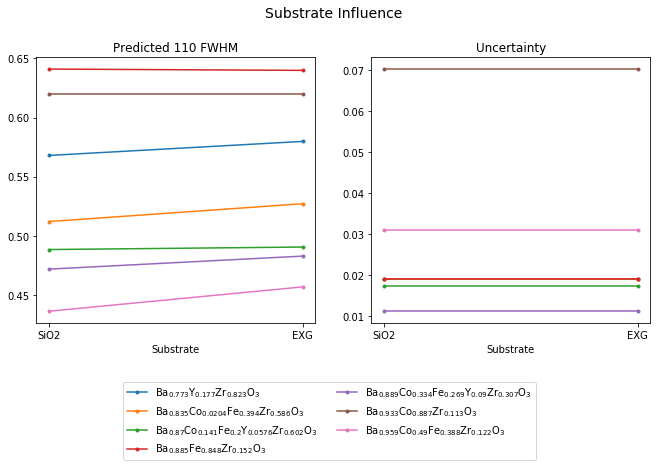

In [9]:
import os
from citrination_client import CitrinationClient
import pandas as pd
import pymatgen as mg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import ternary

client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

#determine fwhm 110 dependence on processing parameters
view_id = '4198'

cand = pd.read_excel(os.path.join('input','predict_candidates.xlsx'))

Asite = ['Ba']
Bsite = ['Co','Fe','Y','Zr']

for i in cand.index:
    comp = mg.Composition(cand.loc[i,'formula'])
    Asum = 0
    Bsum = 0
    for x in comp.elements:
        if str(x) in Asite: 
            Asum += comp.get_el_amt_dict()[str(x)]
        elif str(x) in Bsite:
            Bsum += comp.get_el_amt_dict()[str(x)]
    for x in comp.elements:
        if str(x) in Asite:
            wt = comp.get_el_amt_dict()[str(x)]/Asum #weight for wtd average
            cand.loc[i,'Property A_avg_X'] += wt*x.X
            cand.loc[i,'Property A_avg_at_radius'] += wt*x.atomic_radius
            cand.loc[i,'Property A_avg_ion_radius'] += wt*x.average_ionic_radius
            cand.loc[i,'Property A_avg_mass'] += wt*x.atomic_mass
            
        elif str(x) in Bsite:
            wt = comp.get_el_amt_dict()[str(x)]/Bsum #weight for wtd average
            cand.loc[i,'Property B_avg_X'] += wt*x.X
            cand.loc[i,'Property B_avg_at_radius'] += wt*x.atomic_radius
            cand.loc[i,'Property B_avg_ion_radius'] += wt*x.average_ionic_radius
            cand.loc[i,'Property B_avg_mass'] += wt*x.atomic_mass
            
    cand.loc[i,'Property AB_site_ratio'] = Asum/Bsum
    cand.loc[i,'Property AB_at_radius_ratio'] = cand.loc[i,'Property A_avg_at_radius']/cand.loc[i,'Property B_avg_at_radius']
    #cand.loc[i,'Property AB_ion_radius_ratio'] = cand.loc[i,'Property A_avg_ion_radius']/cand.loc[i,'Property B_avg_ion_radius']
    cand.loc[i,'Property AB_mass_ratio'] = cand.loc[i,'Property A_avg_mass']/cand.loc[i,'Property B_avg_mass']
    
inputs = {}
tests = {'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)':{'shortname':'Pulses/Cycle','suffix':'pulse_rate','units':''},
         'Laser Energy (Step Pulsed Laser Deposition)':{'shortname':'Laser Energy','suffix':'laser_energy','units':'mJ'},
         'Substrate (Step Pulsed Laser Deposition)':{'shortname':'Substrate','suffix':'substrate','units':''}}

for var, vdict in tests.items():
    df = cand[cand.test==var]
    inplist = []
    for i in df.index:
        inp = df.loc[i,'formula':].to_dict()
        for k,v in inp.items(): #need to convert numpy.int64 and numpy.float64 data types to non-numpy data types
            if type(v) != str:
                inp[k] = v.astype(str)
        inplist.append(inp)
    inputs[var] = inplist
    
    view_id = '4198'
    results = client.predict(view_id,inplist)
    candidates = results['candidates']
    
    formula = []
    fwhm = []
    err = []
    x = []

    for i in range(len(candidates)):
        formula.append(candidates[i]['formula'][0])
        fwhm.append(candidates[i]['Property FWHM of 110 peak'][0])
        err.append(candidates[i]['Property FWHM of 110 peak'][1])
        x.append(candidates[i][var][0])

    fig, axes = plt.subplots(1,2,figsize=(11,7))
    for f in np.unique(formula):
        fc = mg.Composition(f).get_el_amt_dict()
        fcstr = ''
        for k, v in fc.items():
            fcstr += k + '$_{{{0:.3g}}}$'.format(v)
        
        start = formula.index(f)
        end = len(formula) - formula[::-1].index(f)
        #plt.errorbar(x[start:end],fwhm[start:end],yerr=err[start:end], capsize = 4, marker='.',label=f)
        axes[0].plot(x[start:end],fwhm[start:end], marker='.',label=fcstr)
        
        axes[1].plot(x[start:end],err[start:end], marker='.',label=fcstr)
        
    testname = vdict['shortname']
    suffix = vdict['suffix']
    units = vdict['units']
    if len(units) > 0:
        xlab = '{} ({})'.format(testname,units)
    else:
        xlab = testname
    
    axes[0].set_xlabel(xlab)
    #axes[0].set_ylabel('Predicted 110 FWHM')
    axes[0].set_title('Predicted 110 FWHM')
    axes[1].set_xlabel(xlab)
    #axes[1].set_ylabel('110 FWHM Uncertainty')
    axes[1].set_title('Uncertainty')
    plt.suptitle(testname + ' Influence',fontsize=14)
    for ax in axes:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height*0.3, box.width, box.height*0.7])
    
    plt.legend(loc='upper center',bbox_to_anchor=(-0.15,-0.2),ncol=2)
    plt.savefig(os.path.join('plots','PredTest_' + suffix),dpi=350)
    

In [122]:
candidates[0]['Property FWHM of 110 peak'][0]

0.5153433889928057

In [2]:
#optimize composition using formula as only input
view_id = '4209'
path = 'output'
design_file = 'design_formulas_180329.csv'
design_inp = pd.read_csv(os.path.join(path,design_file))
inputs = design_inp.to_dict('records')
candidates = []
for i in [0,1000,2000,3000]:
    cand = client.predict(view_id,inputs[i:i+1000])['candidates']
    candidates += cand

In [75]:
len(candidates)

3304

In [76]:
sort_cand = sorted(candidates, key= lambda x: x['Property FWHM of 110 peak'][0])
for cand in sort_cand[0:20]:
    print(cand['formula'],cand['Property FWHM of 110 peak'])

['Ba0.9Co0.273Fe0.364Y0.0Zr0.364O3', 0.0] [0.4465835741379315, 0.017456111259380683]
['Ba0.9Co0.273Fe0.364Y0.0Zr0.364O3', 0.0] [0.4465835741379315, 0.017456111259380683]
['Ba0.9Co0.263Fe0.368Y0.0Zr0.368O3', 0.0] [0.44720812965517287, 0.017456111259380683]
['Ba0.9Co0.28Fe0.36Y0.0Zr0.36O3', 0.0] [0.4475818930268204, 0.017456111259380683]
['Ba0.9Co0.286Fe0.357Y0.0Zr0.357O3', 0.0] [0.44770873072796963, 0.017456111259380683]
['Ba0.9Co0.3Fe0.35Y0.0Zr0.35O3', 0.0] [0.4484753665900385, 0.017456111259380683]
['Ba0.9Co0.294Fe0.353Y0.0Zr0.353O3', 0.0] [0.44851672306513435, 0.017456111259380683]
['Ba0.9Co0.25Fe0.375Y0.0Zr0.375O3', 0.0] [0.44861455053639937, 0.017456111259380683]
['Ba0.9Co0.25Fe0.375Y0.0Zr0.375O3', 0.0] [0.44861455053639937, 0.017456111259380683]
['Ba0.9Co0.25Fe0.375Y0.0Zr0.375O3', 0.0] [0.44861455053639937, 0.017456111259380683]
['Ba0.9Co0.278Fe0.389Y0.0Zr0.333O3', 0.0] [0.4488371883908048, 0.017456111259380683]
['Ba0.9Co0.286Fe0.381Y0.0Zr0.333O3', 0.0] [0.44928146394636026, 0.017

In [73]:
for cand in sort_cand[-10:]:
    print(cand['formula'],cand['Property FWHM of 110 peak'])

['Ba0.8500000000000001Co0.5Fe0.4Zr0.1O3', 0.0] [0.5418814422605359, 0.017456111259380683]
['Ba0.9900000000000002Co0.3Fe0.3Y0.1Zr0.3O3', 0.0] [0.5425162686015327, 0.029228539784347946]
['Ba0.9500000000000002Co0.3Fe0.3Y0.1Zr0.3O3', 0.0] [0.5439549363793104, 0.029228539784347946]
['Ba0.9100000000000001Co0.5Fe0.4Zr0.1O3', 0.0] [0.5445881711111117, 0.017456111259380683]
['Ba1.0000000000000002Co0.3Fe0.3Y0.1Zr0.3O3', 0.0] [0.5454251678927206, 0.029228539784347946]
['Ba0.8400000000000001Co0.5Fe0.4Zr0.1O3', 0.0] [0.5502019857854401, 0.017456111259380683]
['Ba0.8300000000000001Co0.5Fe0.4Zr0.1O3', 0.0] [0.5532051906513408, 0.017456111259380683]
['Ba0.8200000000000001Co0.5Fe0.4Zr0.1O3', 0.0] [0.5603415490804597, 0.017456111259380683]
['Ba0.81Co0.5Fe0.4Zr0.1O3', 0.0] [0.5644999601915704, 0.017456111259380683]
['Ba0.8Co0.5Fe0.4Zr0.1O3', 0.0] [0.568308971532567, 0.017456111259380683]


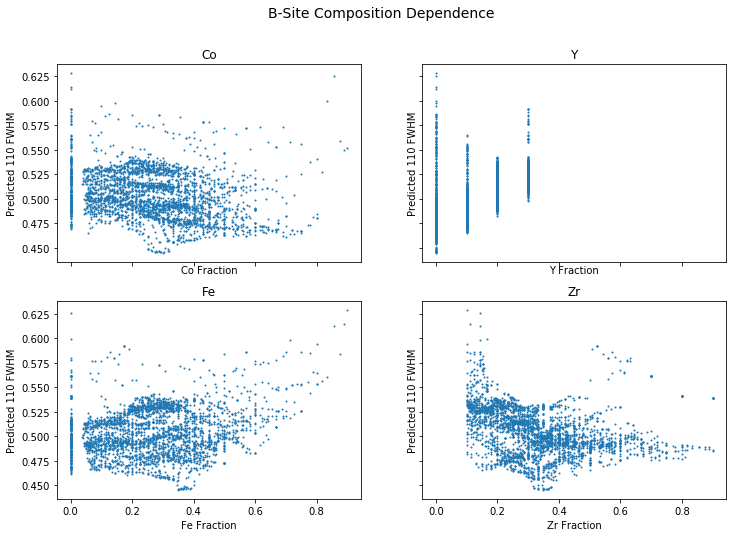

In [4]:
compresults = pd.DataFrame(columns=['formula','Co','Fe','Y','Zr','fwhm_110','error'])
for i, cand in enumerate(candidates):
    comp = mg.Composition(cand['formula'][0])
    compresults.loc[i,'formula'] = cand['formula'][0]
    compresults.loc[i,'fwhm_110':'error'] = cand['Property FWHM of 110 peak']
    for el in Bsite:
        compresults.loc[i,el] = comp.get_el_amt_dict()[el]
    

fig, axes = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True)
for i, el in enumerate(Bsite):
    ax = axes[i%2,int(i/2)]
    ax.plot(compresults[el],compresults.fwhm_110,ls='',marker='.',markersize=2)
    ax.set_title(el)
    ax.set_xlabel(el + ' Fraction')
    ax.set_ylabel('Predicted 110 FWHM')
plt.suptitle('B-Site Composition Dependence',size=14)
plt.savefig(os.path.join('plots','BsiteComp_FWHM110.png'),dpi=350)

Text(0.5,0.98,'B-Site Composition Dependence')

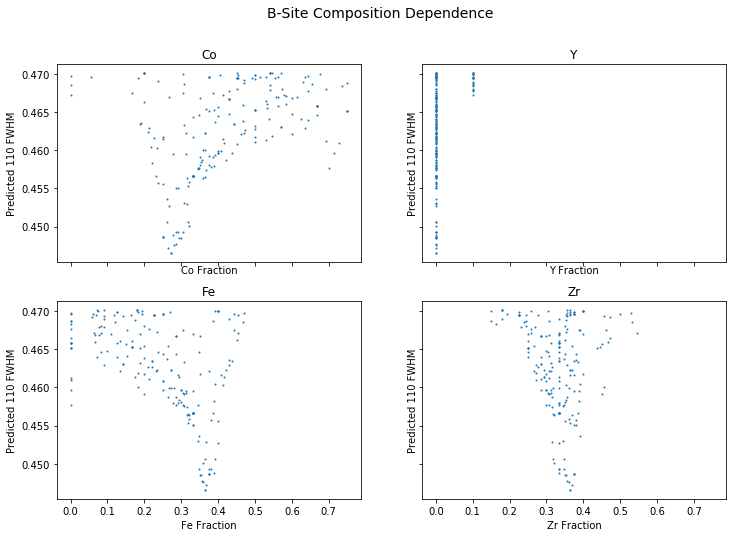

In [6]:
bestresults = pd.DataFrame(columns=['formula','Co','Fe','Y','Zr','fwhm_110','error'])
for i, cand in enumerate(sort_cand[0:200]):
    comp = mg.Composition(cand['formula'][0])
    bestresults.loc[i,'formula'] = cand['formula'][0]
    bestresults.loc[i,'fwhm_110':'error'] = cand['Property FWHM of 110 peak']
    for el in Bsite:
        bestresults.loc[i,el] = comp.get_el_amt_dict()[el]
        
fig, axes = plt.subplots(2,2,figsize=(12,8),sharey=True,sharex=True)
for i, el in enumerate(Bsite):
    ax = axes[i%2,int(i/2)]
    ax.plot(bestresults[el],bestresults.fwhm_110,ls='',marker='.',markersize=2)
    ax.set_title(el)
    ax.set_xlabel(el + ' Fraction')
    ax.set_ylabel('Predicted 110 FWHM')
plt.suptitle('B-Site Composition Dependence',size=14)
#plt.savefig(os.path.join('plots','BsiteComp_FWHM110.png'),dpi=350)

In [12]:
inputs==test

True

In [172]:
min(compresults.loc[:,'fwhm_110'].values)
max(compresults.loc[:,'fwhm_110'].values)

0.6973599965517254

In [122]:
points = compresults.loc[:,['Co','Fe','Zr']].values
colors = compresults.loc[:,'fwhm_110'].values

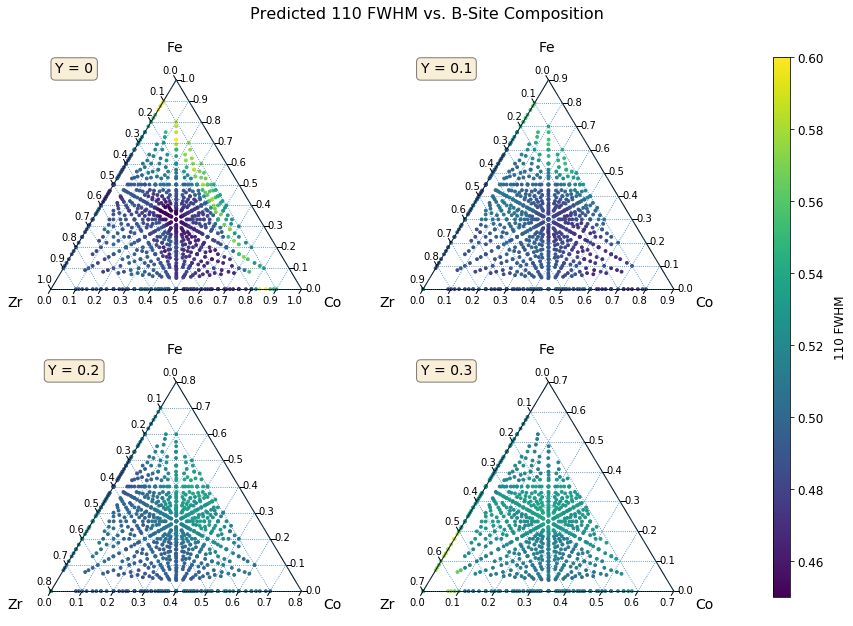

In [11]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compresults.loc[:,'fwhm_110'].values
vmin=0.45
vmax=0.6


for i, nY in enumerate(Y_frac):
    df = compresults[compresults['Y']==nY]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'fwhm_110'].values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    tfig, tax = ternary.figure(scale=scale,ax=ax)
    cmap = plt.cm.viridis
    tax.scatter(points,s=8,vmin=vmin,vmax=vmax,colormap=cmap,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.02)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('Y = {}'.format(nY),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')
    
plt.suptitle('Predicted 110 FWHM vs. B-Site Composition',size=16,y=0.97)

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes)
cb.set_label('110 FWHM', fontsize=12, labelpad=10)
cb.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

plt.savefig(os.path.join('plots','Bsite_fwhm110_ternary_pred_180424.png'),dpi=350)

Text(0.5,0.95,'Prediction Uncertainty vs. B-Site Composition (All Candidates)')

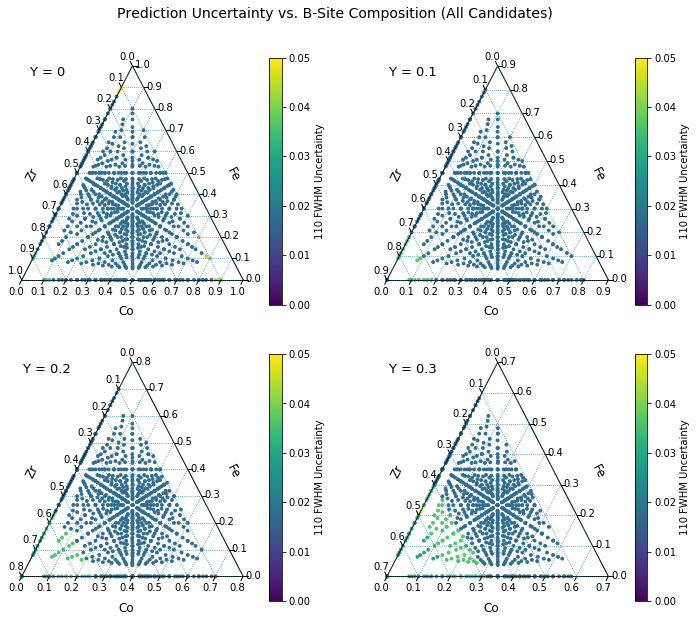

In [22]:
#plot uncertainty
fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = [0,0.1,0.2,0.3]
full_colors = compresults.loc[:,'error'].values

for i, nY in enumerate(Y_frac):
    df = compresults[compresults['Y']==nY]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'error'].values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax.scatter(points,s=8,vmin=0,vmax=0.05,colormap=plt.cm.viridis,
                colorbar=True,c=colors, cbarlabel='110 FWHM Uncertainty')
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.02)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=12)
    tax.right_axis_label('Fe',offset=0.2,fontsize=12)
    tax.left_axis_label('Zr',offset=0.2,fontsize=12)
    tax.set_title('Y = {}'.format(nY),fontsize=13,x=0.15,y=0.9)
    tax._redraw_labels()
    ax.axis('off')
plt.suptitle('Prediction Uncertainty vs. B-Site Composition (All Candidates)',size=14,y=0.95)
#plt.savefig(os.path.join('plots','Bsite_fwhm110_ternary.png'),dpi=350)

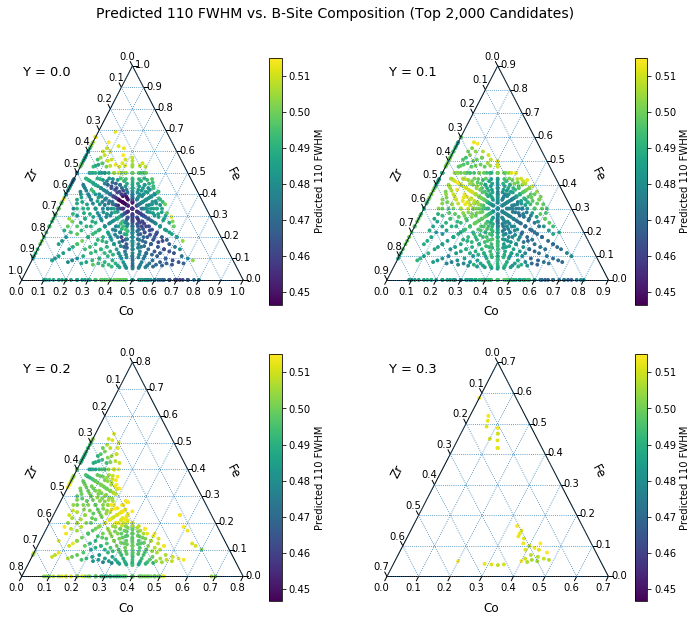

In [107]:
bestresults = pd.DataFrame(columns=['formula','Co','Fe','Y','Zr','fwhm_110','error'])
n = 2000
for i, cand in enumerate(sort_cand[0:n]):
    comp = mg.Composition(cand['formula'][0])
    bestresults.loc[i,'formula'] = cand['formula'][0]
    bestresults.loc[i,'fwhm_110':'error'] = cand['Property FWHM of 110 peak']
    for el in Bsite:
        bestresults.loc[i,el] = comp.get_el_amt_dict()[el]

fig, axes = plt.subplots(2,2,figsize=(12,10))
Y_frac = bestresults['Y'].unique()
full_colors = bestresults.loc[:,'fwhm_110'].values

for i, nY in enumerate(Y_frac):
    df = bestresults[bestresults['Y']==nY]
    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'fwhm_110'].values
    
    ax=axes[int(i/2), i%2]
    
    scale = 1 - nY #point coords must sum to scale
    tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax.scatter(points,s=8,vmin=min(full_colors),vmax=max(full_colors),colormap=plt.cm.viridis,
                colorbar=True,c=colors, cbarlabel='Predicted 110 FWHM')
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.02)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=12)
    tax.right_axis_label('Fe',offset=0.2,fontsize=12)
    tax.left_axis_label('Zr',offset=0.2,fontsize=12)
    tax.set_title('Y = {}'.format(nY),fontsize=13,x=0.15,y=0.9)
    tax._redraw_labels()
    ax.axis('off')
plt.suptitle('Predicted 110 FWHM vs. B-Site Composition (Top {:,} Candidates)'.format(n),size=14,y=0.95)
plt.savefig(os.path.join('plots','Bsite_fwhm110_ternary_pred_best.png'),dpi=350)

In [21]:
compresults[compresults.error>0.1]

,formula,Co,Fe,Y,Zr,fwhm_110,error
54,Ba0.85Co0.0Fe0.875Y0.0Zr0.125O3,0,0.875,0,0.125,0.610745,0.212459
63,Ba0.85Co0.0Fe0.889Y0.0Zr0.111O3,0,0.889,0,0.111,0.585525,0.212459
72,Ba0.85Co0.0Fe0.9Y0.0Zr0.1O3,0,0.9,0,0.1,0.587085,0.212459
2545,Ba0.85Co0.0Fe0.21Y0.3Zr0.49O3,0,0.21,0.3,0.49,0.595681,0.335089
2556,Ba0.85Co0.0Fe0.215Y0.3Zr0.485O3,0,0.215,0.3,0.485,0.594819,0.271015


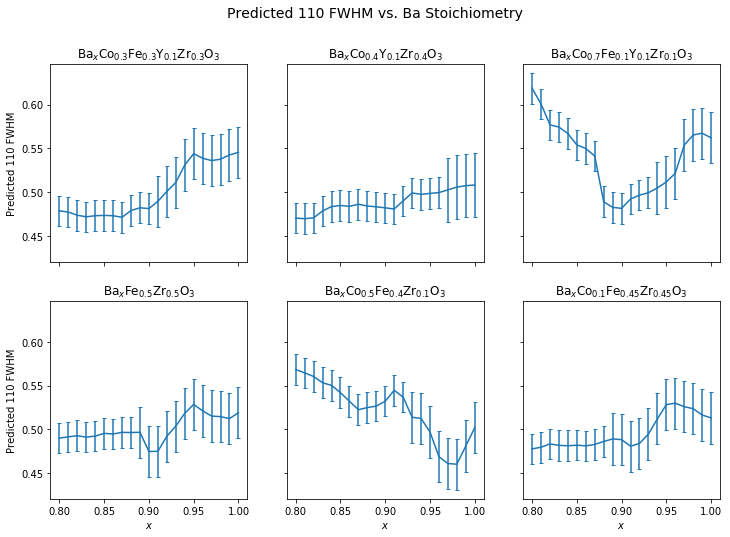

In [106]:
#test impact of Ba amount
Bcomps = ['Co0.3Fe0.3Y0.1Zr0.3', 'Fe0.5Zr0.5', 'Co0.4Y0.1Zr0.4','Co0.5Fe0.4Zr0.1', 'Co0.7Fe0.1Y0.1Zr0.1', 'Co0.1Fe0.45Zr0.45']

Ba_test = pd.DataFrame(columns=['formula','Bcomp','Ba','fwhm_110','error'])
for bc in Bcomps:
    nBa = np.arange(0.8,1.01,0.01)
    for n in nBa:
        frm = 'Ba' + str(n) + bc +'O3'
        Ba_test = Ba_test.append(pd.Series([frm,bc,n], index=['formula','Bcomp','Ba']), ignore_index=True)

inputs = Ba_test.formula.to_frame().to_dict('records')
view_id = '4209'
results = client.predict(view_id,inputs)['candidates']
for i, cand in enumerate(results):
    Ba_test.loc[i,'fwhm_110':'error'] = cand['Property FWHM of 110 peak']
    
fig, axes = plt.subplots(2,3,sharex=True, sharey=True,figsize=(12,8))
for i, bc in enumerate(Bcomps):
    ax = axes[i%2, int(i/2)]
    df = Ba_test[Ba_test['Bcomp']==bc]
    ax.errorbar(x=df['Ba'],y=df['fwhm_110'],yerr=df['error'],label=bc,capsize=2)
    
    bcd = mg.Composition(bc).get_el_amt_dict()
    bcstr = ''
    for k, v in bcd.items():
        bcstr += k + '$_{{{}}}$'.format(v)

    ax.set_title('Ba$_x$' + bcstr + 'O$_3$')
    if i%2 == 1:
        ax.set_xlabel('$x$')
    if int(i/2) == 0:
        ax.set_ylabel('Predicted 110 FWHM')
        
plt.suptitle('Predicted 110 FWHM vs. Ba Stoichiometry',size=14)
plt.savefig('plots/Asite_fwhm110_pred.png',dpi=350)

In [59]:
bcd = mg.Composition(bc).get_el_amt_dict()
bcstr = ''
for k, v in bcd.items():
    bcstr += k + '$_{{{}}}$'.format(v)
bcstr

'Co$_{0.5}$Fe$_{0.4}$Zr$_{0.1}$'

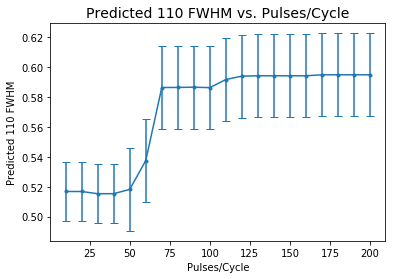

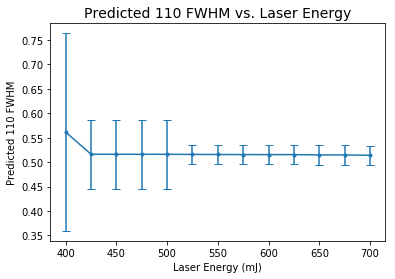

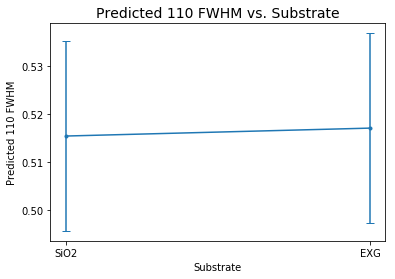

In [117]:
#optimize PLD params for chosen composition
view_id = '4198'

proc_cand = pd.read_excel(os.path.join('input','processing_predict_180330.xlsx'))

Asite = ['Ba']
Bsite = ['Co','Fe','Y','Zr']

for i in proc_cand.index:
    comp = mg.Composition(proc_cand.loc[i,'formula'])
    Asum = 0
    Bsum = 0
    for x in comp.elements:
        if str(x) in Asite: 
            Asum += comp.get_el_amt_dict()[str(x)]
        elif str(x) in Bsite:
            Bsum += comp.get_el_amt_dict()[str(x)]
    for x in comp.elements:
        if str(x) in Asite:
            wt = comp.get_el_amt_dict()[str(x)]/Asum #weight for wtd average
            proc_cand.loc[i,'Property A_avg_X'] += wt*x.X
            proc_cand.loc[i,'Property A_avg_at_radius'] += wt*x.atomic_radius
            proc_cand.loc[i,'Property A_avg_ion_radius'] += wt*x.average_ionic_radius
            proc_cand.loc[i,'Property A_avg_mass'] += wt*x.atomic_mass
            
        elif str(x) in Bsite:
            wt = comp.get_el_amt_dict()[str(x)]/Bsum #weight for wtd average
            proc_cand.loc[i,'Property B_avg_X'] += wt*x.X
            proc_cand.loc[i,'Property B_avg_at_radius'] += wt*x.atomic_radius
            proc_cand.loc[i,'Property B_avg_ion_radius'] += wt*x.average_ionic_radius
            proc_cand.loc[i,'Property B_avg_mass'] += wt*x.atomic_mass
            
    proc_cand.loc[i,'Property AB_site_ratio'] = Asum/Bsum
    proc_cand.loc[i,'Property AB_at_radius_ratio'] = proc_cand.loc[i,'Property A_avg_at_radius']/proc_cand.loc[i,'Property B_avg_at_radius']
    #proc_cand.loc[i,'Property AB_ion_radius_ratio'] = proc_cand.loc[i,'Property A_avg_ion_radius']/cand.loc[i,'Property B_avg_ion_radius']
    proc_cand.loc[i,'Property AB_mass_ratio'] = proc_cand.loc[i,'Property A_avg_mass']/proc_cand.loc[i,'Property B_avg_mass']
    
inputs = {}
tests = {'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)':{'shortname':'Pulses/Cycle','suffix':'pulse_rate','units':''},
         'Laser Energy (Step Pulsed Laser Deposition)':{'shortname':'Laser Energy','suffix':'laser_energy','units':'mJ'},
         'Substrate (Step Pulsed Laser Deposition)':{'shortname':'Substrate','suffix':'substrate','units':''}}


for var, vdict in tests.items():
    df = proc_cand[proc_cand.test==var]
    inplist = []
    for i in df.index:
        inp = df.loc[i,'formula':].to_dict()
        for k,v in inp.items(): #need to convert numpy.int64 and numpy.float64 data types to non-numpy data types
            if type(v) != str:
                inp[k] = v.astype(str)
        inplist.append(inp)
    inputs[var] = inplist
    
    view_id = '4198'
    results = client.predict(view_id,inplist)
    candidates = results['candidates']
    
    formula = []
    fwhm = []
    err = []
    x = []

    for i in range(len(candidates)):
        formula.append(candidates[i]['formula'][0])
        fwhm.append(candidates[i]['Property FWHM of 110 peak'][0])
        err.append(candidates[i]['Property FWHM of 110 peak'][1])
        x.append(candidates[i][var][0])
    
    testname = vdict['shortname']
    suffix = vdict['suffix']
    units = vdict['units']
    if len(units) > 0:
        xlab = '{} ({})'.format(testname,units)
    else:
        xlab = testname
    
    plt.errorbar(x,fwhm,yerr=err,capsize=4,marker='.')
    
    plt.xlabel(xlab)
    plt.ylabel('Predicted 110 FWHM')
    plt.title('Predicted 110 FWHM vs. ' + testname,fontsize=14)
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0 + box.height*0.3, box.width, box.height*0.7])
    
    #plt.legend(loc='upper center',bbox_to_anchor=(-0.15,-0.2),ncol=2)
    plt.savefig(os.path.join('plots','TestComp_' + suffix),dpi=350)
    plt.show()

In [90]:
tdict = {'Test A':{'shortname':'TA','suffix':'ta'}}
tdict['Test A']['suffix']

'ta'

In [97]:
candidates[-3:]

[{'Average Target Pulses/Cycle (Step Pulsed Laser Deposition)': [25.0, 0.0],
  'Deposition Pressure (Step Pulsed Laser Deposition)': [50.0, 0.0],
  'Formula weight for formula': [250.17592150000002, 0.0],
  'Formula weight for formula dopants': [0.0, 0.0],
  'Laser Energy (Step Pulsed Laser Deposition)': [600.0, 0.0],
  'Laser Pulse Frequency (Step Pulsed Laser Deposition)': [10.0, 0.0],
  'Maximum atomic fraction for formula': [0.6, 0.0],
  'Maximum atomic fraction for formula dopants': [0.0, 0.0],
  'Maximum electronegativity difference for formula': [2.55, 0.0],
  'Maximum electronegativity difference for formula dopants': [0.0, 0.0],
  'Maximum radius difference for formula': [149.0, 0.0],
  'Maximum radius difference for formula dopants': [0.0, 0.0],
  'Maximum radius ratio for formula': [3.257575757575758, 0.0],
  'Maximum radius ratio for formula dopants': [0.0, 0.0],
  'Maximum weight fraction for formula': [0.5489217314624741, 0.0],
  'Maximum weight fraction for formula dopan